# compose

In [2]:
from util import compose_all, plot_scores

base_all = ['outputs/model-evaluations-20230519-223940-GILGFVFTL-50-fixed-test-size/scores-20230519-224017.csv',
            'outputs/model-evaluations-20230519-223724-GILGFVFTL-100-fixed-test-size/scores-20230519-223817.csv',
            'outputs/model-evaluations-20230518-133505-GILGFVFTL-200-fixed-test-size/scores-20230518-133605.csv',
            'outputs/model-evaluations-20230518-133659-GILGFVFTL-500-fixed-test-size/scores-20230518-133906.csv',
            'outputs/model-evaluations-20230518-134125-GILGFVFTL-1000-fixed-test-size/scores-20230518-134633.csv',
            'outputs/model-evaluations-20230518-134717-GILGFVFTL-2000-fixed-test-size/scores-20230518-140119.csv',
            'outputs/model-evaluations-20230519-011756-GILGFVFTL-5000-fixed-test-size/scores-20230519-024251.csv',
            'outputs/model-evaluations-20230519-090347-GILGFVFTL-12528-fixed-test-size/scores-20230519-202428.csv']

In [2]:
% % script echo skipping
title = "Impact of dataset size (variable test size)"
df = compose_all(['outputs/model-evaluations-20230518-125400-GILGFVFTL-200/scores-20230518-125447.csv',
                  'outputs/model-evaluations-20230518-125507-GILGFVFTL-500/scores-20230518-125701.csv',
                  'outputs/model-evaluations-20230518-125813-GILGFVFTL-1000/scores-20230518-130302.csv',
                  'outputs/model-evaluations-20230518-130554-GILGFVFTL-2000/scores-20230518-131925.csv'],
                 'composed_data/GILGFVFTL-different-sizes.csv',
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Mean imputed)",
                     "Random Forest (KNN imputed, k=5)",
                     "HistGradientBoosting",
                     "Random Forest (Seperate chains)"
                 ])
plot_scores(df, title, hue="df_size", wrap=True, hue_group_diff=False)

UsageError: Line magic function `%` not found.


In [4]:
# %%script echo skipping

title = "Impact of dataset size (fixed test size)"
# Disclaimer: same test set was (accidentaly) used for all of the 5 folds, training set was different per fold
df = compose_all(base_all,
                 'composed_data/GILGFVFTL-different-sizes-fixed-test-size.csv',
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Mean imputed)",
                     "Random Forest (KNN imputed, k=5)",
                     "HistGradientBoosting",
                     "Random Forest (Seperate chains)"
                 ])
# plot_scores(df, title, hue="df_size", wrap=True, hue_group_diff=False)

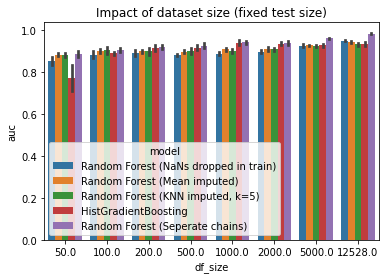

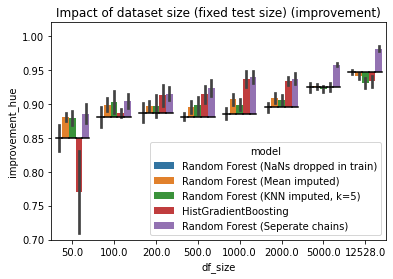

In [5]:
plot_scores(df, title, wrap=True, x="df_size", hue="model")

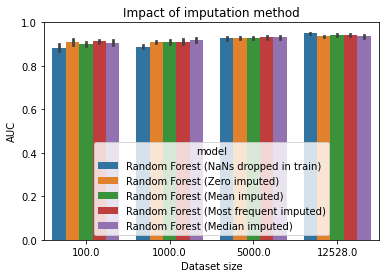

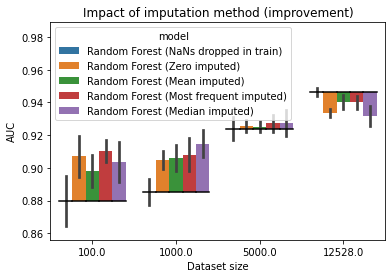

In [6]:
title = "Impact of imputation method"

df = compose_all(base_all,
                 None,
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Zero imputed)",
                     "Random Forest (Mean imputed)",
                     "Random Forest (Most frequent imputed)",
                     "Random Forest (Median imputed)"
                 ],
                 attributes_to_keep={
                     "df_size": [100, 1000, 5000, 12528]
                 })

output = 'graphs/GILGFVFTL-simple-imputation-methods.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

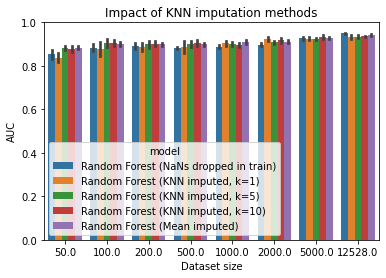

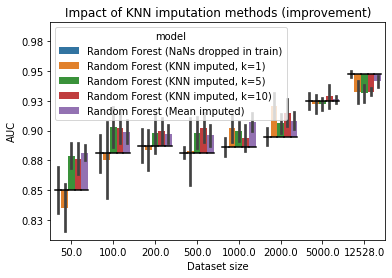

In [7]:
title = "Impact of KNN imputation methods"

df = compose_all(base_all,
                 None,
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (KNN imputed, k=1)",
                     'Random Forest (KNN imputed, k=5)',
                     'Random Forest (KNN imputed, k=10)',
                     "Random Forest (Mean imputed)",
                 ])

output = 'graphs/GILGFVFTL-knn-imputation-methods.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

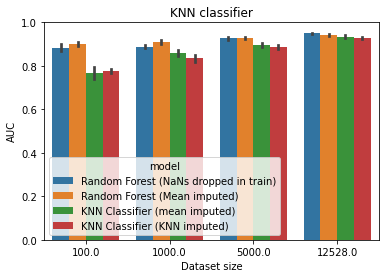

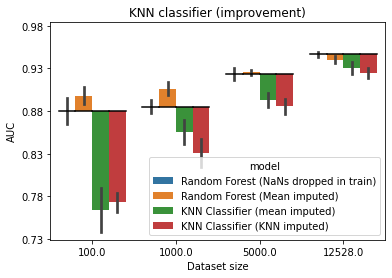

In [8]:
title = "KNN classifier"

df = compose_all(base_all,
                 None,
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Mean imputed)",
                     "KNN Classifier (mean imputed)",
                     "KNN Classifier (KNN imputed)"
                 ],
                 attributes_to_keep={
                     "df_size": [100, 1000, 5000, 12528]
                 })

output = 'graphs/GILGFVFTL-knn-classifier.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

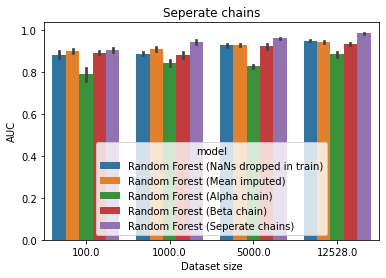

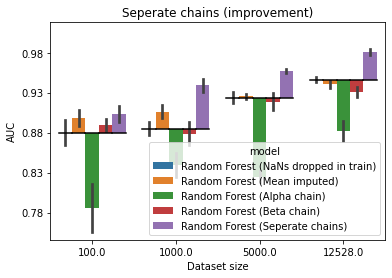

In [9]:
title = "Seperate chains"

df = compose_all(base_all,
                 None,
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Mean imputed)",
                     "Random Forest (Alpha chain)",
                     "Random Forest (Beta chain)",
                     "Random Forest (Seperate chains)"
                 ],
                 attributes_to_keep={
                     "df_size": [100, 1000, 5000, 12528]
                 })

output = 'graphs/GILGFVFTL-seperate-chains.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

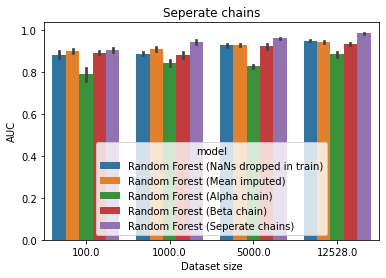

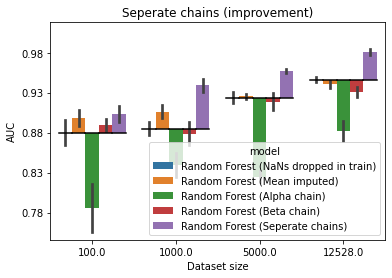

In [10]:
title = "Seperate chains"

df = compose_all(base_all,
                 None,
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Mean imputed)",
                     "Random Forest (Alpha chain)",
                     "Random Forest (Beta chain)",
                     "Random Forest (Seperate chains)"
                 ],
                 attributes_to_keep={
                     "df_size": [100, 1000, 5000, 12528]
                 })

output = 'graphs/GILGFVFTL-seperate-chains.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

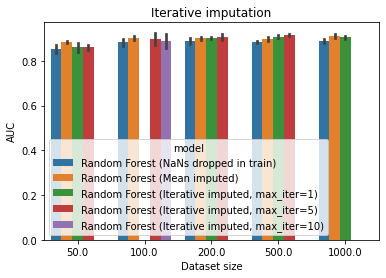

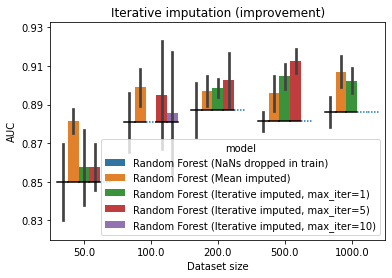

In [11]:
title = "Iterative imputation"

iterative_results = [
    'outputs/model-evaluations-20230521-200717-GILGFVFTL-50--iterative-imputers/1-Random Forest (Iterative imputed, max_iter=1).csv',
    'outputs/model-evaluations-20230521-200717-GILGFVFTL-50--iterative-imputers/2-Random Forest (Iterative imputed, max_iter=5).csv',

    'outputs/model-evaluations-20230521-202243-GILGFVFTL-100--iterative-imputers/2-Random Forest (Iterative imputed, max_iter=5).csv',
    'outputs/model-evaluations-20230521-202243-GILGFVFTL-100--iterative-imputers/3-Random Forest (Iterative imputed, max_iter=10).csv',

    'outputs/model-evaluations-20230522-071321-GILGFVFTL-200--iterative-imputers/scores-20230522-072955.csv',

    'outputs/model-evaluations-20230522-073856-GILGFVFTL-500--iterative-imputers/scores-20230522-084148.csv',

    'outputs/model-evaluations-20230522-155837-GILGFVFTL-1000--iterative-imputers/1-Random Forest (Iterative imputed, max_iter=1).csv']

df = compose_all(base_all + iterative_results,
                 None,
                 models_to_keep=["Random Forest (NaNs dropped in train)",
                                 "Random Forest (Mean imputed)",
                                 "Random Forest (Iterative imputed, max_iter=1)",
                                 "Random Forest (Iterative imputed, max_iter=5)",
                                 "Random Forest (Iterative imputed, max_iter=10)"],
                 attributes_to_keep={'df_size': [50, 100, 200, 500, 1000]})

output = 'graphs/GILGFVFTL-iterative-imputers.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

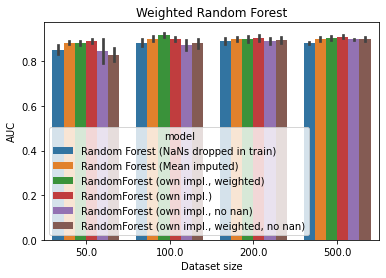

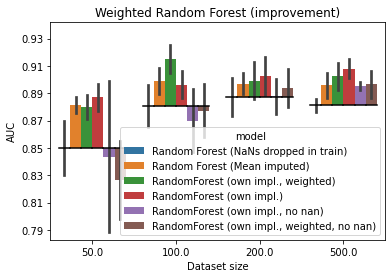

Unnamed: 0            \
                                                         mean       std   
df_size model                                                             
50.0    Random Forest (Mean imputed)                      2.0  1.581139   
        Random Forest (NaNs dropped in train)             2.0  1.581139   
        RandomForest (own impl.)                          2.0  1.581139   
        RandomForest (own impl., no nan)                  2.0  1.581139   
        RandomForest (own impl., weighted)                2.0  1.581139   
        RandomForest (own impl., weighted, no nan)        2.0  1.581139   
100.0   Random Forest (Mean imputed)                      2.0  1.581139   
        Random Forest (NaNs dropped in train)             2.0  1.581139   
        RandomForest (own impl.)                          2.0  1.581139   
        RandomForest (own impl., no nan)                  2.0  1.581139   
        RandomForest (own impl., weighted)                2.0  1.581139   
        RandomForest (own impl., weighted, no nan)        2.0  1.581139   
200.0   Random Forest (Mean imputed)                      2.0  1.581139   
        Random Forest (NaNs dropped in train)             2.0  1.581139   
        RandomForest (own impl.)                          2.0  1.581139   
        RandomForest (own impl., no nan)                  2.0  1.581139   
        RandomForest (own impl., weighted)                2.0  1.581139   
        RandomForest (own impl., weighted, no nan)        2.0  1.581139   
500.0   Random Forest (Mean imputed)                      2.0  1.581139   
        Random Forest (NaNs dropped in train)             2.0  1.581139   
        RandomForest (own impl.)                          2.0  1.581139   
        RandomForest (own impl., no nan)                  2.0  1.581139   
        RandomForest (own impl., weighted)                2.0  1.581139   
        RandomForest (own impl., weighted, no nan)        2.0  1.581139   

                                                         auc            \
                                                        mean       std   
df_size model                                                            
50.0    Random Forest (Mean imputed)                0.883897  0.006767   
        Random Forest (NaNs dropped in train)       0.852414  0.021799   
        RandomForest (own impl.)                    0.889448  0.010766   
        RandomForest (own impl., no nan)            0.846138  0.061895   
        RandomForest (own impl., weighted)          0.882241  0.010013   
        RandomForest (own impl., weighted, no nan)  0.828862  0.032056   
100.0   Random Forest (Mean imputed)                0.901379  0.010863   
        Random Forest (NaNs dropped in train)       0.883310  0.017121   
        RandomForest (own impl.)                    0.898793  0.010772   
        RandomForest (own impl., no nan)            0.872448  0.026038   
        RandomForest (own impl., weighted)          0.917759  0.011501   
        RandomForest (own impl., weighted, no nan)  0.879759  0.021898   
200.0   Random Forest (Mean imputed)                0.899448  0.008643   
        Random Forest (NaNs dropped in train)       0.889690  0.015638   
        RandomForest (own impl.)                    0.905069  0.015167   
        RandomForest (own impl., no nan)            0.890345  0.014303   
        RandomForest (own impl., weighted)          0.901759  0.015013   
        RandomForest (own impl., weighted, no nan)  0.896276  0.015316   
500.0   Random Forest (Mean imputed)                0.898241  0.010236   
        Random Forest (NaNs dropped in train)       0.883793  0.005381   
        RandomForest (own impl.)                    0.910483  0.007514   
        RandomForest (own impl., no nan)            0.897759  0.003529   
        RandomForest (own impl., weighted)          0.904724  0.011231   
        RandomForest (own impl., weighted, no nan)  0.899138  0.011058   

                          

In [31]:
title = "Weighted Random Forest"

df = compose_all(
    base_all + ['outputs/model-evaluations-20230522-203946-GILGFVFTL-50-weighted-rf/scores-20230522-204407.csv',
                'outputs/model-evaluations-20230522-204411-GILGFVFTL-100-weighted-rf/scores-20230522-205100.csv',
                'outputs/model-evaluations-20230522-205105-GILGFVFTL-200-weighted-rf/scores-20230522-211114.csv',
                'outputs/model-evaluations-20230522-213519-GILGFVFTL-500-weighted-rf/scores-20230522-232154.csv'],
    None,
    models_to_keep=["Random Forest (NaNs dropped in train)",
                    "Random Forest (Mean imputed)",
                    "RandomForest (own impl., weighted)",
                    "RandomForest (own impl.)",
                    "RandomForest (own impl., no nan)",
                    "RandomForest (own impl., weighted, no nan)"],
    attributes_to_keep={'df_size': [50, 100, 200, 500]})


output = 'graphs/GILGFVFTL-weighted-rf.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

df.groupby(['df_size', 'model']).agg(['mean', 'std'])

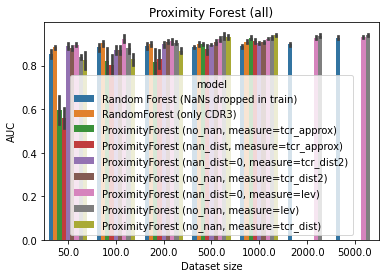

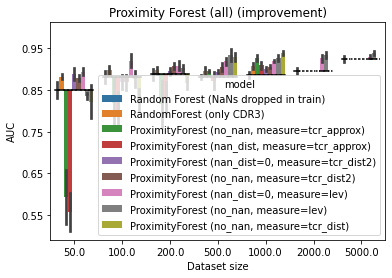

In [41]:
title = "Proximity Forest (all)"

proximity_models = [
    'outputs/model-evaluations-20230523-160628-GILGFVFTL-50-distance-models-cdr/scores-20230523-160732.csv',
    'outputs/model-evaluations-20230523-160737-GILGFVFTL-100-distance-models-cdr/scores-20230523-160931.csv',
    'outputs/model-evaluations-20230523-160936-GILGFVFTL-200-distance-models-cdr/scores-20230523-161238.csv',
    'outputs/model-evaluations-20230523-163303-GILGFVFTL-500-distance-models-cdr/scores-20230523-164535.csv',
    'outputs/model-evaluations-20230523-164543-GILGFVFTL-1000-distance-models-cdr/scores-20230523-170918.csv',

    'outputs/model-evaluations-20230523-191340-GILGFVFTL-50-distance-models-cdr/scores-20230523-191424.csv',
    'outputs/model-evaluations-20230523-191428-GILGFVFTL-100-distance-models-cdr/scores-20230523-191550.csv',
    'outputs/model-evaluations-20230523-191555-GILGFVFTL-200-distance-models-cdr/scores-20230523-191834.csv',
    'outputs/model-evaluations-20230523-191840-GILGFVFTL-500-distance-models-cdr/scores-20230523-192808.csv',
    'outputs/model-evaluations-20230523-192816-GILGFVFTL-1000-distance-models-cdr/scores-20230523-195447.csv',

    'outputs/model-evaluations-20230523-225602-GILGFVFTL-50-distance-models-cdr-tcr-dist2/scores-20230523-225704.csv',
    'outputs/model-evaluations-20230523-225611-GILGFVFTL-50-distance-models-cdr-lev/scores-20230523-225954.csv',
    'outputs/model-evaluations-20230523-225710-GILGFVFTL-100-distance-models-cdr-tcr-dist2/scores-20230523-225851.csv',
    'outputs/model-evaluations-20230523-225856-GILGFVFTL-200-distance-models-cdr-tcr-dist2/scores-20230523-230141.csv',
    'outputs/model-evaluations-20230523-225958-GILGFVFTL-100-distance-models-cdr-lev/scores-20230523-230659.csv',
    'outputs/model-evaluations-20230523-230147-GILGFVFTL-500-distance-models-cdr-tcr-dist2/scores-20230523-232509.csv',
    'outputs/model-evaluations-20230523-230704-GILGFVFTL-200-distance-models-cdr-lev/scores-20230523-232028.csv',
    'outputs/model-evaluations-20230523-232034-GILGFVFTL-500-distance-models-cdr-lev/scores-20230523-234855.csv',
    'outputs/model-evaluations-20230523-232518-GILGFVFTL-1000-distance-models-cdr-tcr-dist2/scores-20230524-020042.csv',
    'outputs/model-evaluations-20230523-234903-GILGFVFTL-1000-distance-models-cdr-lev/scores-20230524-003951.csv',
    'outputs/model-evaluations-20230524-004003-GILGFVFTL-2000-distance-models-cdr-lev/scores-20230524-022222.csv',
    'outputs/model-evaluations-20230524-022248-GILGFVFTL-5000-distance-models-cdr-lev/scores-20230524-063154.csv',

]

df = compose_all(
    base_all + proximity_models,
    None,
    models_to_keep=["Random Forest (NaNs dropped in train)",
                    "RandomForest (only CDR3)",
                    "ProximityForest (no_nan, measure=tcr_approx)",
                    "ProximityForest (nan_dist, measure=tcr_approx)",
                    "ProximityForest (nan_dist=0, measure=tcr_dist2)",
                    "ProximityForest (no_nan, measure=tcr_dist2)",
                    "ProximityForest (nan_dist=0, measure=lev)",
                    "ProximityForest (no_nan, measure=lev)",
                    "ProximityForest (no_nan, measure=tcr_dist)",
                    "ProximityForest (nan_dist=150, measure=tcr_dist)"  # is er nog niet denk ik
                    ],
    attributes_to_keep={'df_size': [50, 100, 200, 500, 1000, 2000, 5000]})

output = 'graphs/GILGFVFTL-proximity-forest-all.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

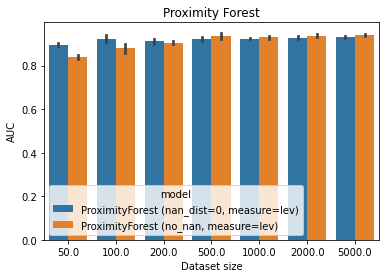

Baseline ProximityForest (nan_dist=0, measure=lev) not found in scores, using ProximityForest (nan_dist=0, measure=lev) instead


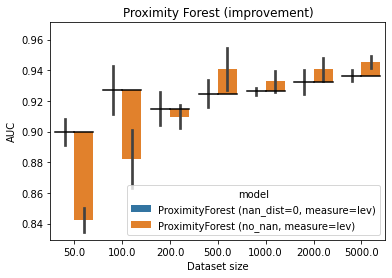

In [44]:
df = df[df.model.isin(["ProximityForest (nan_dist=0, measure=lev)",
                    "ProximityForest (no_nan, measure=lev)"])]

output = 'graphs/GILGFVFTL-proximity-forest-lev.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

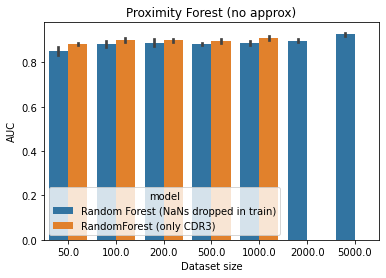

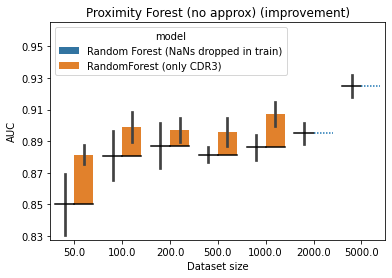

In [14]:
title = "Proximity Forest (no approx)"
df = compose_all(
    base_all + proximity_models,
    None,
    models_to_keep=["Random Forest (NaNs dropped in train)",
                    "RandomForest (only CDR3)",
                    "RandomForest (mean imputed)"
                    # "ProximityForest (nan_dist=0, measure=tcr_dist2)",
                    # "ProximityForest (no_nan, measure=tcr_dist2)",
                    # "ProximityForest (nan_dist=0, measure=lev)",
                    # "ProximityForest (no_nan, measure=lev)",
                    # "ProximityForest (no_nan, measure=tcr_dist)",
                    # "ProximityForest (nan_dist=150, measure=tcr_dist)" # is er nog niet denk ik
                    ],
    attributes_to_keep={'df_size': [50, 100, 200, 500, 1000, 2000, 5000]})

output = 'graphs/GILGFVFTL-proximity-forest-all-noaproox.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

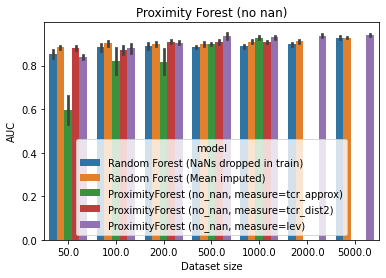

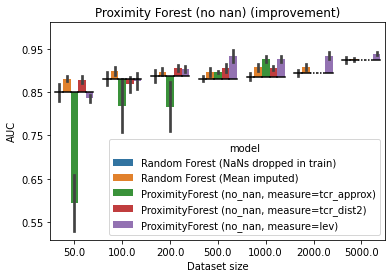

Unnamed: 0            \
                                                           mean       std   
df_size model                                                               
50.0    ProximityForest (no_nan, measure=lev)               2.0  1.581139   
        ProximityForest (no_nan, measure=tcr_approx)        2.0  1.581139   
        ProximityForest (no_nan, measure=tcr_dist2)         2.0  1.581139   
        Random Forest (Mean imputed)                        2.0  1.581139   
        Random Forest (NaNs dropped in train)               2.0  1.581139   
100.0   ProximityForest (no_nan, measure=lev)               2.0  1.581139   
        ProximityForest (no_nan, measure=tcr_approx)        2.0  1.581139   
        ProximityForest (no_nan, measure=tcr_dist2)         2.0  1.581139   
        Random Forest (Mean imputed)                        2.0  1.581139   
        Random Forest (NaNs dropped in train)               2.0  1.581139   
200.0   ProximityForest (no_nan, measure=lev)               2.0  1.581139   
        ProximityForest (no_nan, measure=tcr_approx)        2.0  1.581139   
        ProximityForest (no_nan, measure=tcr_dist2)         2.0  1.581139   
        Random Forest (Mean imputed)                        2.0  1.581139   
        Random Forest (NaNs dropped in train)               2.0  1.581139   
500.0   ProximityForest (no_nan, measure=lev)               2.0  1.581139   
        ProximityForest (no_nan, measure=tcr_approx)        2.0  1.581139   
        ProximityForest (no_nan, measure=tcr_dist2)         2.0  1.581139   
        Random Forest (Mean imputed)                        2.0  1.581139   
        Random Forest (NaNs dropped in train)               2.0  1.581139   
1000.0  ProximityForest (no_nan, measure=lev)               2.0  1.581139   
        ProximityForest (no_nan, measure=tcr_approx)        2.0  1.581139   
        ProximityForest (no_nan, measure=tcr_dist2)         2.0  1.581139   
        Random Forest (Mean imputed)                        2.0  1.581139   
        Random Forest (NaNs dropped in train)               2.0  1.581139   
2000.0  ProximityForest (no_nan, measure=lev)               2.0  1.581139   
        Random Forest (Mean imputed)                        2.0  1.581139   
        Random Forest (NaNs dropped in train)               2.0  1.581139   
5000.0  ProximityForest (no_nan, measure=lev)               2.0  1.581139   
        Random Forest (Mean imputed)                        2.0  1.581139   
        Random Forest (NaNs dropped in train)               2.0  1.581139   

                                                           auc            \
                                                          mean       std   
df_size model                                                              
50.0    ProximityForest (no_nan, measure=lev)         0.838310  0.008883   
        ProximityForest (no_nan, measure=tcr_approx)  0.595552  0.072497   
        ProximityForest (no_nan, measure=tcr_dist2)   0.881172  0.008702   
        Random Forest (Mean imputed)                  0.883897  0.006767   
        Random Forest (NaNs dropped in train)         0.852414  0.021799   
100.0   ProximityForest (no_nan, measure=lev)         0.878483  0.021167   
        ProximityForest (no_nan, measure=tcr_approx)  0.821552  0.067936   
        ProximityForest (no_nan, measure=tcr_dist2)   0.870931  0.019477   
        Random Forest (Mean imputed)                  0.901379  0.010863   
        Random Forest (NaNs dropped in train)         0.883310  0.017121   
200.0   ProximityForest (no_nan, measure=lev)         0.905862  0.008387   
        ProximityForest (no_nan, measure=tcr_approx)  0.818310  0.063208   
        ProximityForest (no_nan, measure=tcr_dist2)   0.909103  0.007967   
        Random Forest (Mean imputed)                  0.899448  0.008643   
        Random Forest (NaNs dropped in train)         0.889690  0.015638   
500.0   ProximityForest (no_nan, measure=lev)         0.936966  0.

In [39]:
title = "Proximity Forest (no nan)"

df = compose_all(
    base_all + proximity_models,
    None,
    models_to_keep=["Random Forest (NaNs dropped in train)",
                    "Random Forest (Mean imputed)",
                    "ProximityForest (no_nan, measure=tcr_approx)",
                    "ProximityForest (no_nan, measure=tcr_dist2)",
                    "ProximityForest (no_nan, measure=lev)"],
    attributes_to_keep={'df_size': [50, 100, 200, 500, 1000, 2000, 5000]})

output = 'graphs/GILGFVFTL-proximity-forest-nonan.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

# print means and stds
df.groupby(['df_size', 'model']).agg(['mean', 'std'])

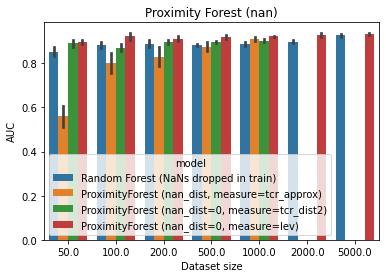

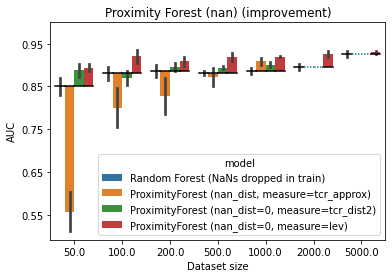

In [16]:
title = "Proximity Forest (nan)"

df = compose_all(
    base_all + proximity_models,
    None,
    models_to_keep=["Random Forest (NaNs dropped in train)",
                    "ProximityForest (nan_dist, measure=tcr_approx)",
                    "ProximityForest (nan_dist=0, measure=tcr_dist2)",
                    "ProximityForest (nan_dist=0, measure=lev)"],
    attributes_to_keep={'df_size': [50, 100, 200, 500, 1000, 2000, 5000]})

output = 'graphs/GILGFVFTL-proximity-forest-nonan.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

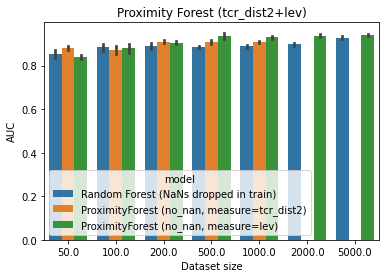

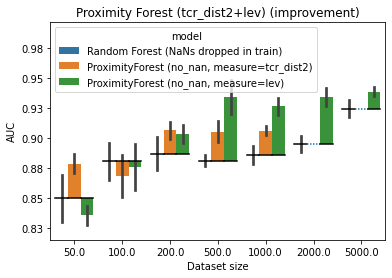

In [17]:
title = "Proximity Forest (tcr_dist2+lev)"

df = compose_all(
    base_all + proximity_models,
    None,
    models_to_keep=["Random Forest (NaNs dropped in train)",
                    "ProximityForest (no_nan, measure=tcr_dist2)",
                    "ProximityForest (no_nan, measure=lev)"],
    attributes_to_keep={'df_size': [50, 100, 200, 500, 1000, 2000, 5000]})

output = 'graphs/GILGFVFTL-proximity-forest-nonan.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

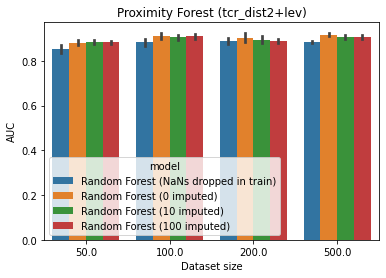

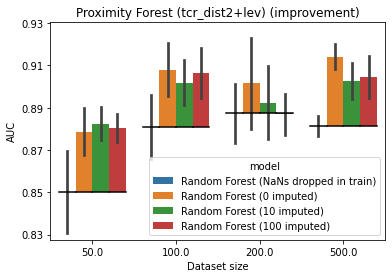

In [5]:
title = "Proximity Forest (tcr_dist2+lev)"

num_imp_models = [
    'outputs/model-evaluations-20230613-152945-GILGFVFTL-50-imputation-constant-numbers/scores-20230613-153001.csv',
    'outputs/model-evaluations-20230613-153007-GILGFVFTL-100-imputation-constant-numbers/scores-20230613-153018.csv',
    'outputs/model-evaluations-20230613-153025-GILGFVFTL-200-imputation-constant-numbers/scores-20230613-153038.csv',
    'outputs/model-evaluations-20230613-153048-GILGFVFTL-500-imputation-constant-numbers/scores-20230613-153110.csv',

]

df = compose_all(
    base_all + num_imp_models,
    None,
    models_to_keep=["Random Forest (NaNs dropped in train)",
                    "Random Forest (0 imputed)",
                    "Random Forest (10 imputed)",
                    "Random Forest (100 imputed)",
                    "Random Forest (mean imputed)"],
    attributes_to_keep={'df_size': [50, 100, 200, 500]})

output = 'graphs/GILGFVFTL-proximity-forest-nonan.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

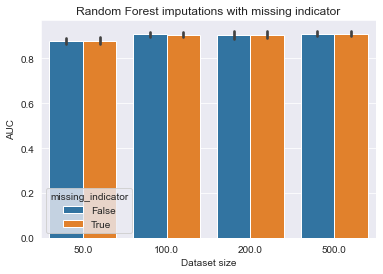

Baseline Random Forest (NaNs dropped in train) not found in scores, using Random Forest (Zero imputed) instead


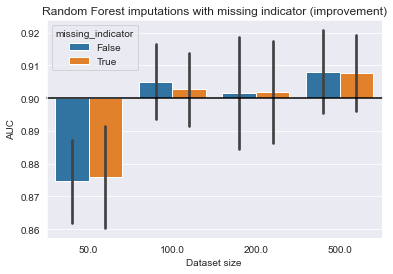

In [4]:
title = "Random Forest imputations with missing indicator"

missing_indicator_models = [
    'outputs/model-evaluations-20230613-175411-GILGFVFTL-50-imputation-constant-numbers/scores-20230613-175440.csv',
    'outputs/model-evaluations-20230613-175448-GILGFVFTL-100-imputation-constant-numbers/scores-20230613-175531.csv',
    'outputs/model-evaluations-20230613-175538-GILGFVFTL-200-imputation-constant-numbers/scores-20230613-175614.csv',
    'outputs/model-evaluations-20230613-175623-GILGFVFTL-500-imputation-constant-numbers/scores-20230613-175728.csv',
]

df = compose_all(missing_indicator_models)

output = 'graphs/GILGFVFTL-missing-indicator.png'
plot_scores(df, title, wrap=True, x="df_size", hue="missing_indicator", xlabel="Dataset size", ylabel="AUC",
            output_file=output,
            plot=True, hue_group_diff=False)

In [ ]:
#

In [3]:
# same, but plot per model
title = "Random Forest imputations with missing indicator"

# remove " (with missing indicator)" from model names
df.model = df.model.apply(lambda x: x.replace(" (with missing indicator)", ""))

models = df.model.unique()

for model in models:
    df_model = df[df.model == model]
    output = 'graphs/GILGFVFTL-missing-indicator-{}.png'.format(model)
    plot_scores(df_model, title, wrap=True, x="df_size", hue="missing_indicator", xlabel="Dataset size", ylabel="AUC",
                output_file=output,
                plot=True, hue_group_diff=False)

NameError: name 'df' is not defined

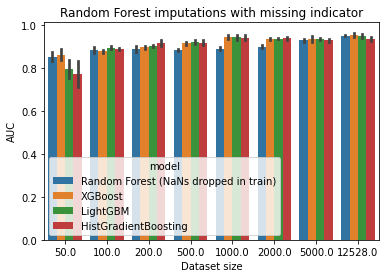

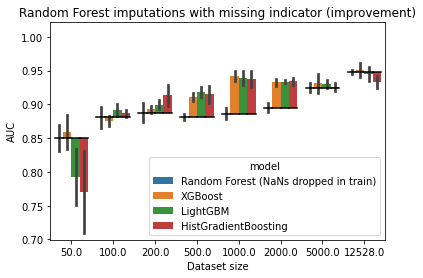

In [16]:
df = compose_all(base_all,
                 attributes_to_keep={'group': ['baseline', 'gradient_boosting']})

output = 'graphs/GILGFVFTL-gradient-boosting.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

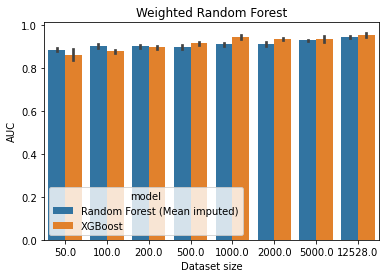

Baseline Random Forest (Mean imputed) not found in scores, using Random Forest (Mean imputed) instead


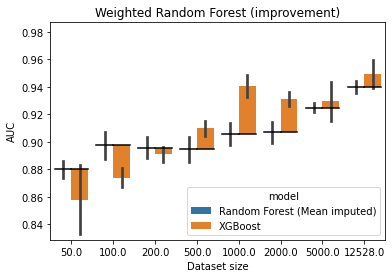

In [32]:
# xgboost vs rf mean imputed

df = compose_all(base_all,
                 attributes_to_keep={'model': ['Random Forest (Mean imputed)',
                                               'XGBoost']})

output = 'graphs/GILGFVFTL-xgboost-vs-rf-mean-imputed.png'

plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

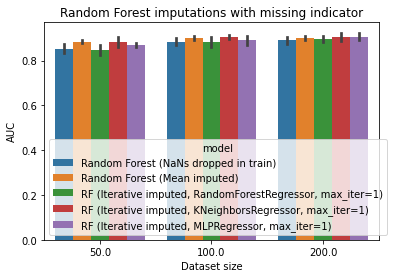

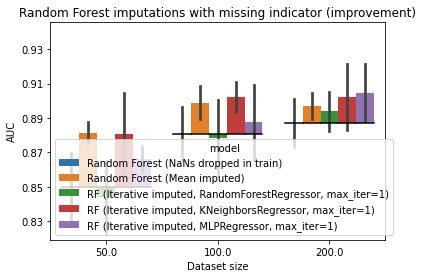

In [19]:
iterative_imputer_regressions = [
    'outputs/model-evaluations-20230613-191059-GILGFVFTL-50-imputation-constant-numbers/scores-20230613-193349.csv',
    'outputs/model-evaluations-20230613-193353-GILGFVFTL-100-imputation-constant-numbers/scores-20230613-200847.csv',
    'outputs/model-evaluations-20230613-200852-GILGFVFTL-200-imputation-constant-numbers/scores-20230613-211135.csv'
]

df = compose_all(base_all + iterative_imputer_regressions,
                 attributes_to_keep={'model': ['Random Forest (NaNs dropped in train)',
                                               'Random Forest (Mean imputed)',
                                               'RF (Iterative imputed, RandomForestRegressor, max_iter=1)',
                                               'RF (Iterative imputed, KNeighborsRegressor, max_iter=1)',
                                               'RF (Iterative imputed, MLPRegressor, max_iter=1)'],
                                     'df_size': [50, 100, 200]})

output = 'graphs/GILGFVFTL-iterative-imputer-regressions.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

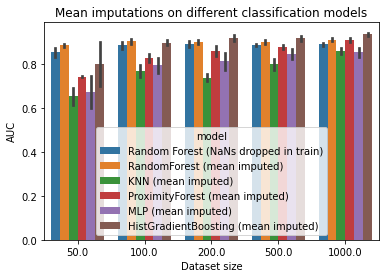

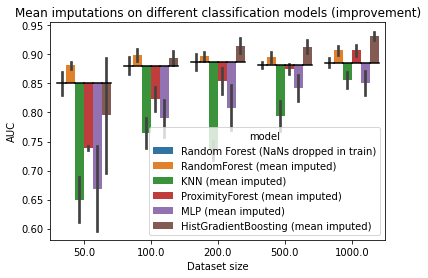

In [34]:
title = "Mean imputations on different classification models"

mean_imputations = [
    'outputs/model-evaluations-20230613-230024-GILGFVFTL-50-imputation-constant-numbers/scores-20230613-230046.csv',
    'outputs/model-evaluations-20230613-230051-GILGFVFTL-100-imputation-constant-numbers/scores-20230613-230126.csv',
    'outputs/model-evaluations-20230613-230131-GILGFVFTL-200-imputation-constant-numbers/scores-20230613-230231.csv',
    'outputs/model-evaluations-20230613-230237-GILGFVFTL-500-imputation-constant-numbers/scores-20230613-230454.csv',
'outputs/model-evaluations-20230614-000827-GILGFVFTL-1000-imputation-constant-numbers/scores-20230614-002205.csv']

df = compose_all(base_all + mean_imputations,
                 attributes_to_keep={
                     'model': ['Random Forest (NaNs dropped in train)', 'RandomForest (mean imputed)',
                               'KNN (mean imputed)', 'ProximityForest (mean imputed)',
                               'MLP (mean imputed)', 'HistGradientBoosting (mean imputed)'],
                     'df_size': [50, 100, 200, 500, 1000]})

output = 'graphs/GILGFVFTL-mean-imputations.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

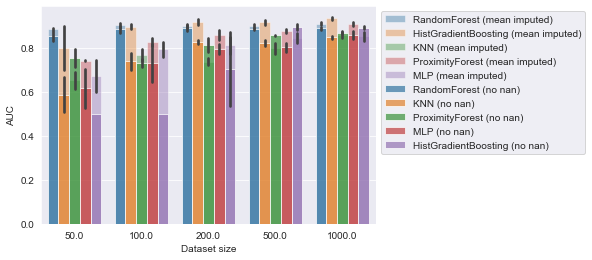

In [3]:
title = "Mean imputations on different classification models"

no_nan = ['outputs/model-evaluations-20230614-165919-GILGFVFTL-50-imputation-constant-numbers/scores-20230614-165929.csv', 'outputs/model-evaluations-20230614-165942-GILGFVFTL-100-imputation-constant-numbers/scores-20230614-170002.csv', 'outputs/model-evaluations-20230614-170020-GILGFVFTL-200-imputation-constant-numbers/scores-20230614-170101.csv', 'outputs/model-evaluations-20230614-170113-GILGFVFTL-500-imputation-constant-numbers/scores-20230614-170218.csv', 'outputs/model-evaluations-20230614-170237-GILGFVFTL-1000-imputation-constant-numbers/scores-20230614-170418.csv']

mean_imputations = [
    'outputs/model-evaluations-20230613-230024-GILGFVFTL-50-imputation-constant-numbers/scores-20230613-230046.csv',
    'outputs/model-evaluations-20230613-230051-GILGFVFTL-100-imputation-constant-numbers/scores-20230613-230126.csv',
    'outputs/model-evaluations-20230613-230131-GILGFVFTL-200-imputation-constant-numbers/scores-20230613-230231.csv',
    'outputs/model-evaluations-20230613-230237-GILGFVFTL-500-imputation-constant-numbers/scores-20230613-230454.csv',
'outputs/model-evaluations-20230614-000827-GILGFVFTL-1000-imputation-constant-numbers/scores-20230614-002205.csv']

df = compose_all(mean_imputations + no_nan,
                 attributes_to_keep={
                     'df_size': [50, 100, 200, 500, 1000]})

# remove (...) from model names
# df['model'] = df['model'].str.replace(r"\(.*\)","")

output = 'graphs/GILGFVFTL-mean-imputations-no-nan.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True, baseline_name=None,
            improvement_config={'value': 'model_train_nan',
                                'legend_outside': True})

In [6]:
df

,Unnamed: 0,model,auc,model_train_nan,imputer,chain,group,seed,epitope,species,train_alpha_only,train_beta_only,train_both,train_non,train_total,test_total,df_size,gene_features,missing_indicator,test_nr
0,0,RandomForest,0.882586,True,NaN,both,mean_impute_models,0.0,GILGFVFTL,HomoSapiens,8.0,23.0,9.0,0.0,40.0,108.0,50.0,NaN,False,1
1,1,RandomForest,0.872586,True,NaN,both,mean_impute_models,1.0,GILGFVFTL,HomoSapiens,12.0,21.0,7.0,0.0,40.0,108.0,50.0,NaN,False,1
2,2,RandomForest,0.887759,True,NaN,both,mean_impute_models,2.0,GILGFVFTL,HomoSapiens,13.0,20.0,7.0,0.0,40.0,108.0,50.0,NaN,False,1
3,3,RandomForest,0.888621,True,NaN,both,mean_impute_models,3.0,GILGFVFTL,HomoSapiens,11.0,22.0,7.0,0.0,40.0,108.0,50.0,NaN,False,1
4,4,RandomForest,0.887931,True,NaN,both,mean_impute_models,4.0,GILGFVFTL,HomoSapiens,10.0,22.0,8.0,0.0,40.0,108.0,50.0,NaN,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,0,HistGradientBoosting,0.928966,True,NaN,both,mean_impute_models,0.0,GILGFVFTL,HomoSapiens,262.0,338.0,200.0,0.0,800.0,108.0,1000.0,NaN,False,5
21,1,HistGradientBoosting,0.942414,True,NaN,both,mean_impute_models,1.0,GILGFVFTL,HomoSapiens,258.0,330.0,212.0,0.0,800.0,108.0,1000.0,NaN,False,5
22,2,HistGradientBoosting,0.931379,True,NaN,both,mean_impute_models,2.0,GILGFVFTL,HomoSapiens,254.0,335.0,211.0,0.0,800.0,108.0,1000.0,NaN,False,5
23,3,HistGradientBoosting,0.926552,True,NaN,both,mean_impute_models,3.0,GILGFVFTL,HomoSapiens,259.0,337.0,204.0,0.0,800.0,108.0,1000.0,NaN,False,5


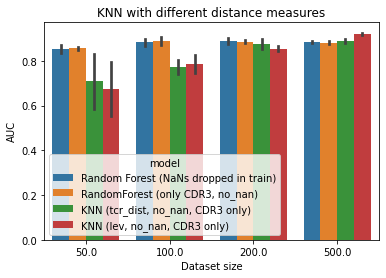

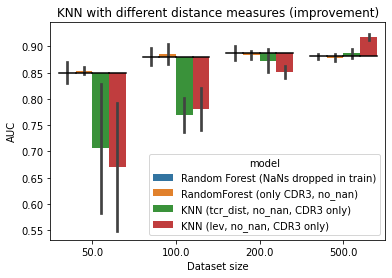

In [27]:
title = "KNN with different distance measures"

knn_dist_measures = [
    'outputs/model-evaluations-20230613-232124-GILGFVFTL-50-imputation-constant-numbers/scores-20230613-232132.csv',
    'outputs/model-evaluations-20230613-232136-GILGFVFTL-100-imputation-constant-numbers/scores-20230613-232152.csv',
    'outputs/model-evaluations-20230613-232157-GILGFVFTL-200-imputation-constant-numbers/scores-20230613-232238.csv',
    'outputs/model-evaluations-20230613-232244-GILGFVFTL-500-imputation-constant-numbers/scores-20230613-232432.csv']

rf_cdr_only = ['outputs/model-evaluations-20230613-234527-GILGFVFTL-50-imputation-constant-numbers/scores-20230613-234529.csv', 'outputs/model-evaluations-20230613-234534-GILGFVFTL-100-imputation-constant-numbers/scores-20230613-234537.csv', 'outputs/model-evaluations-20230613-234542-GILGFVFTL-200-imputation-constant-numbers/scores-20230613-234545.csv', 'outputs/model-evaluations-20230613-234552-GILGFVFTL-500-imputation-constant-numbers/scores-20230613-234555.csv']

df = compose_all(base_all + rf_cdr_only + knn_dist_measures,
                 attributes_to_keep={
                     'model': ['Random Forest (NaNs dropped in train)',
                               'RandomForest (only CDR3, no_nan)',
                               'KNN (tcr_dist, no_nan, CDR3 only)',
                               'KNN (lev, no_nan, CDR3 only)',
                               # 'KNN (hamming, no_nan, CDR3 only)',
                               # 'KNN (tcrdist3, no_nan, CDR3 only)'
                               ],
                     'df_size': [50, 100, 200, 500]})

output = 'graphs/GILGFVFTL-knn-dist-measures.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

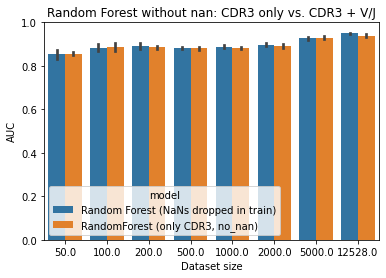

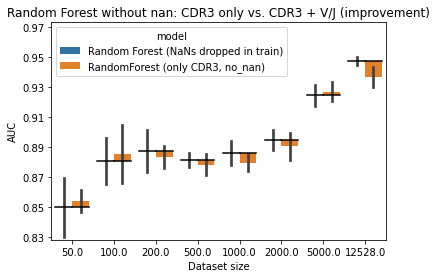

In [26]:
title = "Random Forest without nan: CDR3 only vs. CDR3 + V/J"

rf_cdr_only = ['outputs/model-evaluations-20230613-234726-GILGFVFTL-50-imputation-constant-numbers/scores-20230613-234729.csv', 'outputs/model-evaluations-20230613-234740-GILGFVFTL-100-imputation-constant-numbers/scores-20230613-234742.csv', 'outputs/model-evaluations-20230613-234749-GILGFVFTL-200-imputation-constant-numbers/scores-20230613-234754.csv', 'outputs/model-evaluations-20230613-234805-GILGFVFTL-500-imputation-constant-numbers/scores-20230613-234812.csv', 'outputs/model-evaluations-20230613-234830-GILGFVFTL-1000-imputation-constant-numbers/scores-20230613-234834.csv', 'outputs/model-evaluations-20230613-234851-GILGFVFTL-2000-imputation-constant-numbers/scores-20230613-234858.csv', 'outputs/model-evaluations-20230613-234929-GILGFVFTL-5000-imputation-constant-numbers/scores-20230613-234947.csv', 'outputs/model-evaluations-20230613-235103-GILGFVFTL-12528-imputation-constant-numbers/scores-20230613-235211.csv']

df = compose_all(base_all + rf_cdr_only,
                 attributes_to_keep={
                     'model': ['Random Forest (NaNs dropped in train)',
                               'RandomForest (only CDR3, no_nan)']})

output = 'graphs/GILGFVFTL-rf-cdr-only.png'

plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

In [ ]:
gradint niet: gaat fout gelabelde dingen harder promoten
waat mee doen? vaak vaccin of immunotapie: juiste epitopen bij vaccin, tceellen
vaccin (bv. mrna: gaat omgezet wordn door je cellen in epitopp), heb je tcellden die daat gaan herkennen (niet altijd ghet geeval)
best aan pieter nog eens navragen

uit kanker epitopeen halen, dan specifiek tcellen aanmaken aartificieel die da kunnn aanvallen

hoeveelheid: per epitoop een lijntje hoeveel tcellen ervoor zijn